In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv (r'/content/npa1.csv')
data.head()

,S.N.,Open,High,Low,Close,Change,Per Change (%),Turnover,Date
0,1,"2,772.23","2,805.57","2,742.53","2,755.62",-5.29,-0.19,"21,713,431,007.73",8/1/2024
1,2,"2,708.24","2,791.02","2,707.57","2,760.90",64.25,2.38,"21,911,503,161.05",7/31/2024
2,3,"2,669.41","2,709.89","2,609.02","2,696.65",35.55,1.33,"17,266,391,542.96",7/30/2024
3,1,"2,706.73","2,737.68","2,655.15","2,661.09",-20.46,-0.76,"19,609,177,106.29",7/29/2024
4,2,"2,606.42","2,708.58","2,606.40","2,681.56",113.42,4.41,"15,810,596,235.45",7/28/2024


In [37]:
# Convert the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

data = data.sort_values(by='Date')
data.head()

,S.N.,Open,High,Low,Close,Change,Per Change (%),Turnover,Date
2196,314,904,904,904,904,1.35,0.15,0,2015-01-01
2195,313,918,918,918,918,13.82,1.53,0,2015-01-04
2194,312,920,920,920,920,2.27,0.25,0,2015-01-05
2193,311,917,917,917,917,-2.36,-0.26,0,2015-01-06
2192,310,925,925,925,925,7.13,0.78,0,2015-01-07


In [38]:

# Remove commas from the numerical columns and convert them to float
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High'] = data['High'].str.replace(',', '').astype(float)
data['Low'] = data['Low'].str.replace(',', '').astype(float)
data['Close'] = data['Close'].str.replace(',', '').astype(float)
data['Turnover'] = data['Turnover'].str.replace(',', '').astype(float)

# Create moving averages
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()

# Create lag features
data['Lag1'] = data['Close'].shift(1)
data['Lag2'] = data['Close'].shift(2)
data['Lag3'] = data['Close'].shift(3)

# Extract date features
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['DayOfWeek'] = data['Date'].dt.dayofweek

# Drop rows with NaN values that were created by rolling window and lagging
data = data.dropna()

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Select the features for modeling
features = ['Close', 'MA7', 'MA30', 'Lag1', 'Lag2', 'Lag3']
train_X = train[features].values
train_y = train['Close'].values
test_X = test[features].values
test_y = test['Close'].values

# Scale the features
scaler_X = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_X.fit_transform(train_X)
test_X_scaled = scaler_X.transform(test_X)

# Scale the target (Close price)
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y_scaled = scaler_y.fit_transform(train_y.reshape(-1, 1))
test_y_scaled = scaler_y.transform(test_y.reshape(-1, 1))

# Reshape the data to be compatible with LSTM [samples, time steps, features]
train_X_scaled = train_X_scaled.reshape((train_X_scaled.shape[0], 1, train_X_scaled.shape[1]))
test_X_scaled = test_X_scaled.reshape((test_X_scaled.shape[0], 1, test_X_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, len(features))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(train_X_scaled, train_y_scaled, batch_size=1, epochs=10)

# Make predictions
train_predict_scaled = model.predict(train_X_scaled)
test_predict_scaled = model.predict(test_X_scaled)

# Inverse transform the predictions
train_predict = scaler_y.inverse_transform(train_predict_scaled)
test_predict = scaler_y.inverse_transform(test_predict_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(train_y, train_predict))
test_rmse = np.sqrt(mean_squared_error(test_y, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1734/1734 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0110
Epoch 2/10
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 4.2480e-04
Epoch 3/10
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.7761e-04
Epoch 4/10
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.2848e-04
Epoch 5/10
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2.0223e-04
Epoch 6/10
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.7730e-04
Epoch 7/10
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.8551e-04
Epoch 8/10
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.4805e-04
Epoch 9/10
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.7704e-04
Epoch 10/10
1734/1734 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1.3845e-04


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE: 19.897298910340023
Test RMSE: 26.02243777688299


In [48]:
# Calculate MSE
train_mse = mean_squared_error(train_y, train_predict)
test_mse = mean_squared_error(test_y, test_predict)
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 395.90250392741825
Test MSE: 677.167267851747


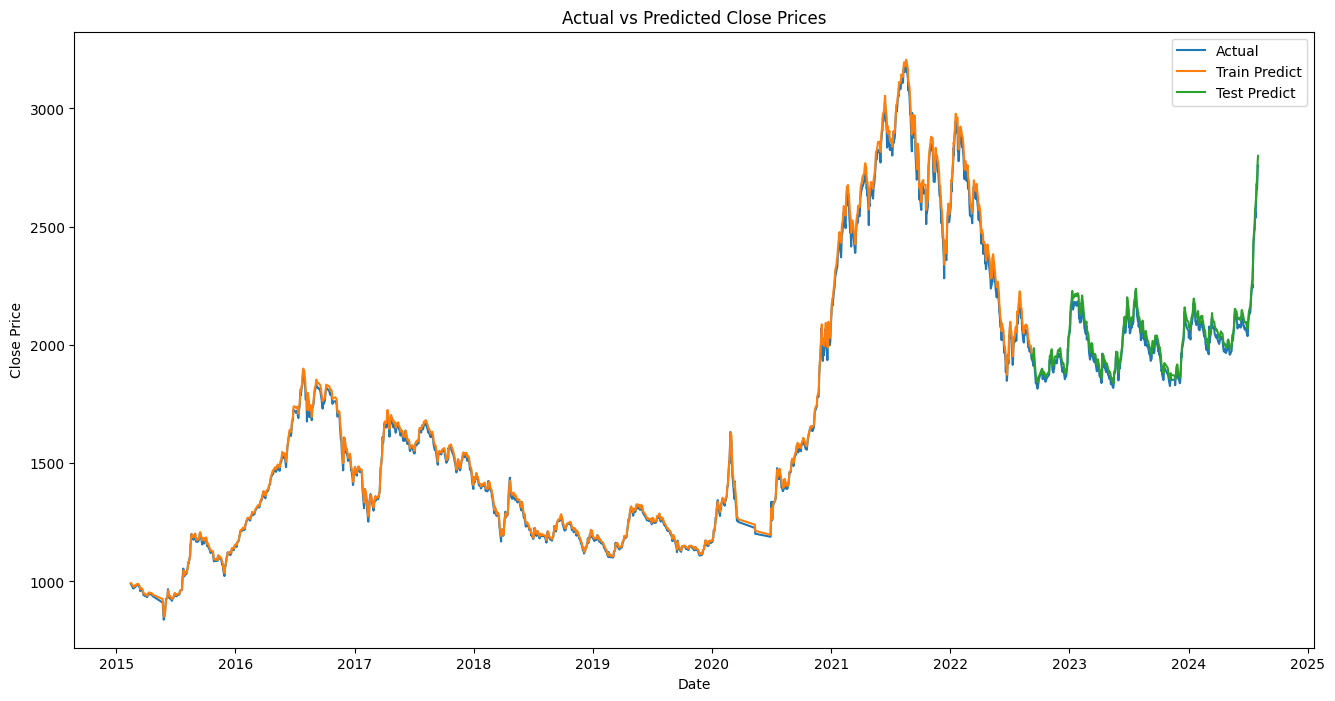

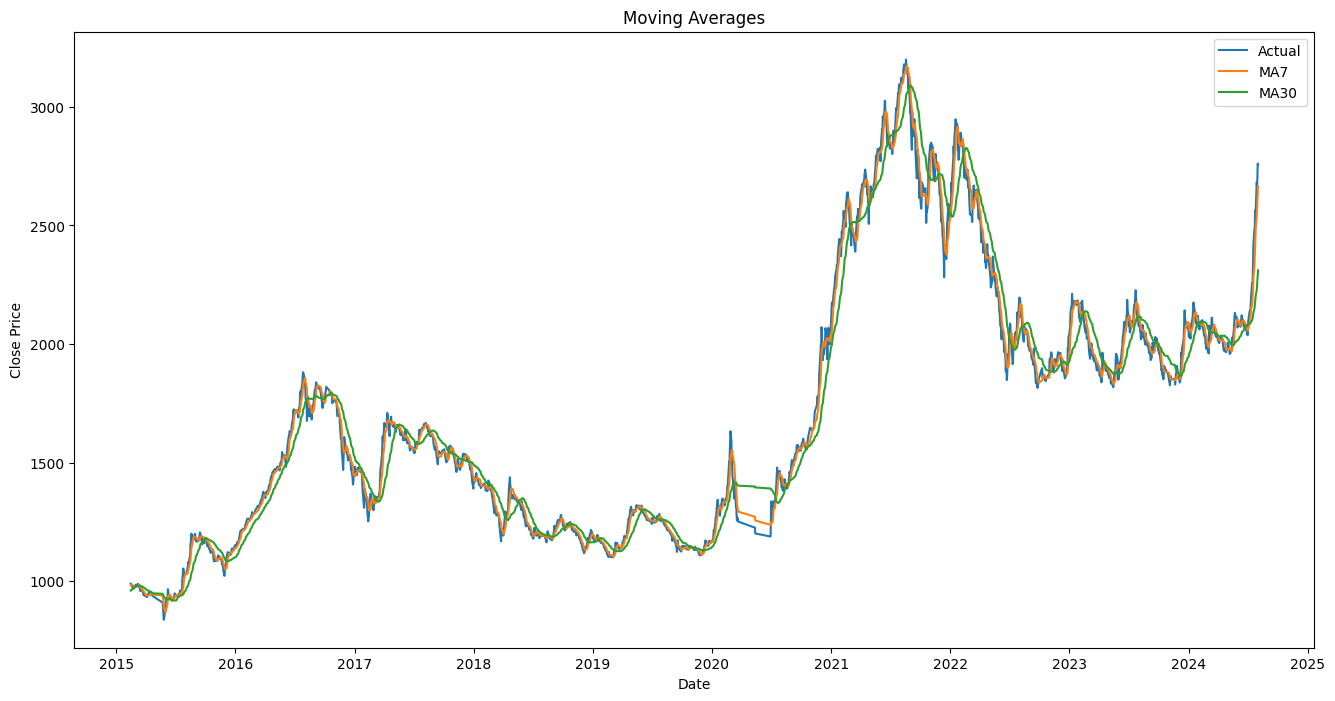

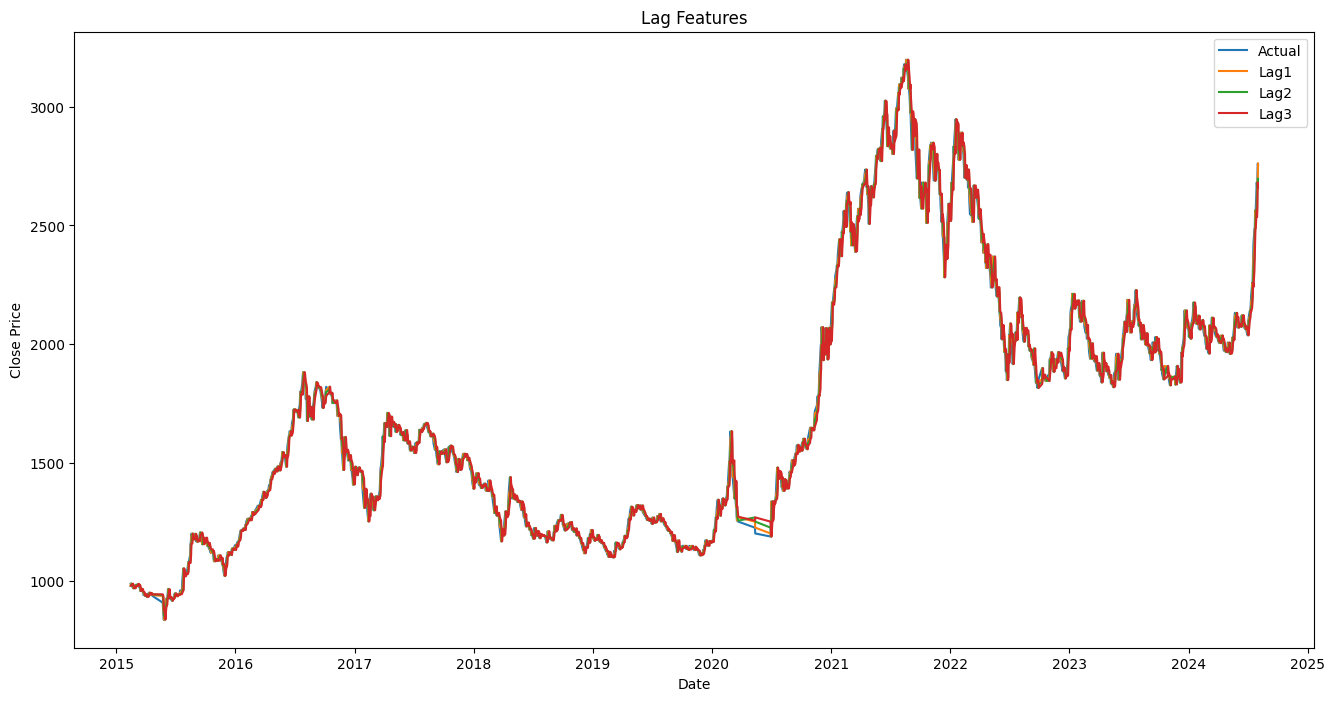

In [40]:

# Plot the results: Actual vs Predicted Close Prices
plt.figure(figsize=(16,8))
plt.plot(data['Date'], data['Close'], label='Actual')
plt.plot(data['Date'][:train_size], train_predict, label='Train Predict')
plt.plot(data['Date'][train_size:], test_predict, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()

# Plot the Moving Averages
plt.figure(figsize=(16,8))
plt.plot(data['Date'], data['Close'], label='Actual')
plt.plot(data['Date'], data['MA7'], label='MA7')
plt.plot(data['Date'], data['MA30'], label='MA30')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('Moving Averages')
plt.show()

# Plot the Lag Features
plt.figure(figsize=(16,8))
plt.plot(data['Date'], data['Close'], label='Actual')
plt.plot(data['Date'], data['Lag1'], label='Lag1')
plt.plot(data['Date'], data['Lag2'], label='Lag2')
plt.plot(data['Date'], data['Lag3'], label='Lag3')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('Lag Features')
plt.show()

In [41]:

# Prepare the last available data point for future prediction
last_data_point = data[features].iloc[-1].values.reshape(1, -1)
scaled_last_data_point = scaler_X.transform(last_data_point)

# Initialize lists to store future predictions
future_predictions = []
num_future_days = 60  # Number of future days to predict

# Predict future values
for _ in range(num_future_days):
    scaled_last_data_point = scaled_last_data_point.reshape((1, 1, len(features)))
    future_pred_scaled = model.predict(scaled_last_data_point)
    future_pred = scaler_y.inverse_transform(future_pred_scaled)

    # Append the prediction to the future_predictions list
    future_predictions.append(future_pred[0][0])

    # Update the scaled_last_data_point with the new predicted value
    new_data_point = np.append(scaled_last_data_point.flatten()[1:], future_pred_scaled)
    scaled_last_data_point = new_data_point.reshape(1, -1)

# Create a DataFrame for future predictions
future_dates = pd.date_range(data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=num_future_days)
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Close': future_predictions})



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

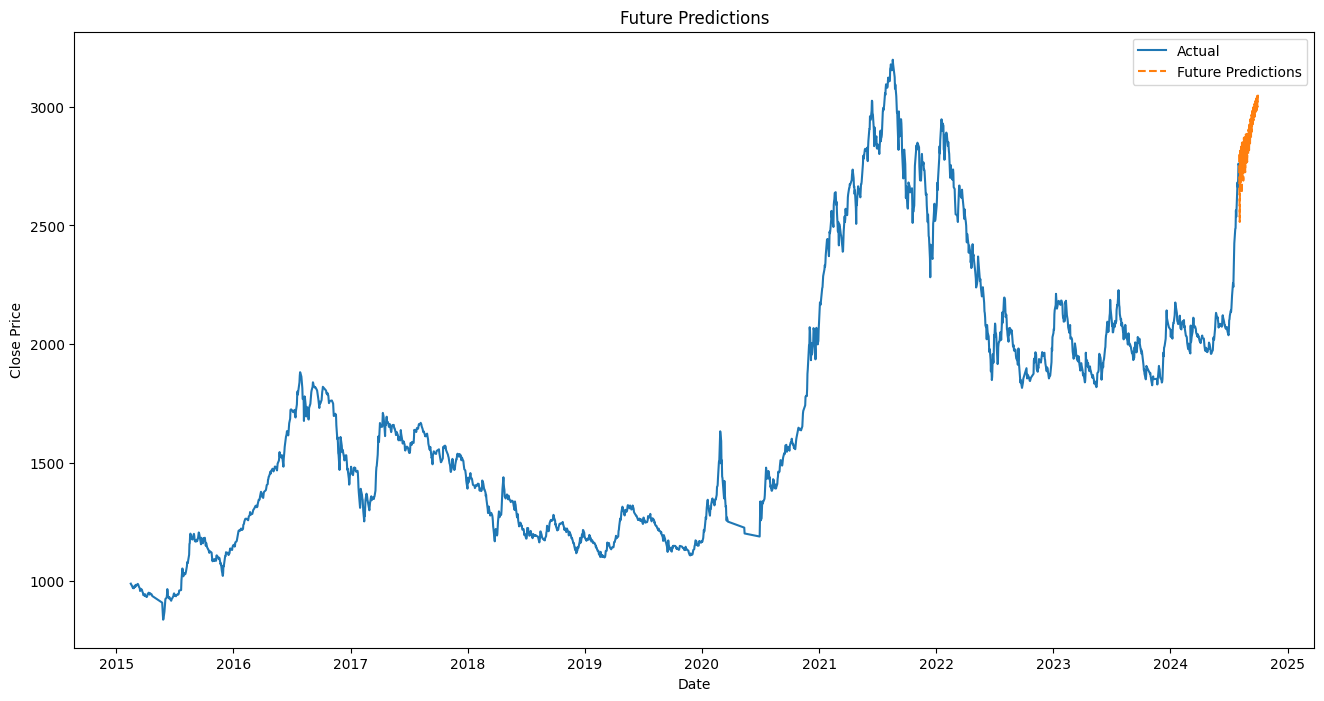

         Date  Predicted Close
0  2024-08-02      2799.733398
1  2024-08-03      2657.175537
2  2024-08-04      2514.851562
3  2024-08-05      2814.691650
4  2024-08-06      2699.040039
5  2024-08-07      2681.740234
6  2024-08-08      2831.860352
7  2024-08-09      2664.708740
8  2024-08-10      2635.893555
9  2024-08-11      2848.899170
10 2024-08-12      2705.564697
11 2024-08-13      2732.910645
12 2024-08-14      2854.996826
13 2024-08-15      2688.897217
14 2024-08-16      2732.025146
15 2024-08-17      2869.862061
16 2024-08-18      2724.614258
17 2024-08-19      2793.423340
18 2024-08-20      2871.800049
19 2024-08-21      2724.431396
20 2024-08-22      2810.321533
21 2024-08-23      2883.757812
22 2024-08-24      2756.447021
23 2024-08-25      2852.253906
24 2024-08-26      2885.403809
25 2024-08-27      2768.203613
26 2024-08-28      2873.978271
27 2024-08-29      2895.501221
28 2024-08-30      2798.155762
29 2024-08-31      2904.209473
30 2024-09-01      2898.856689
31 2024-

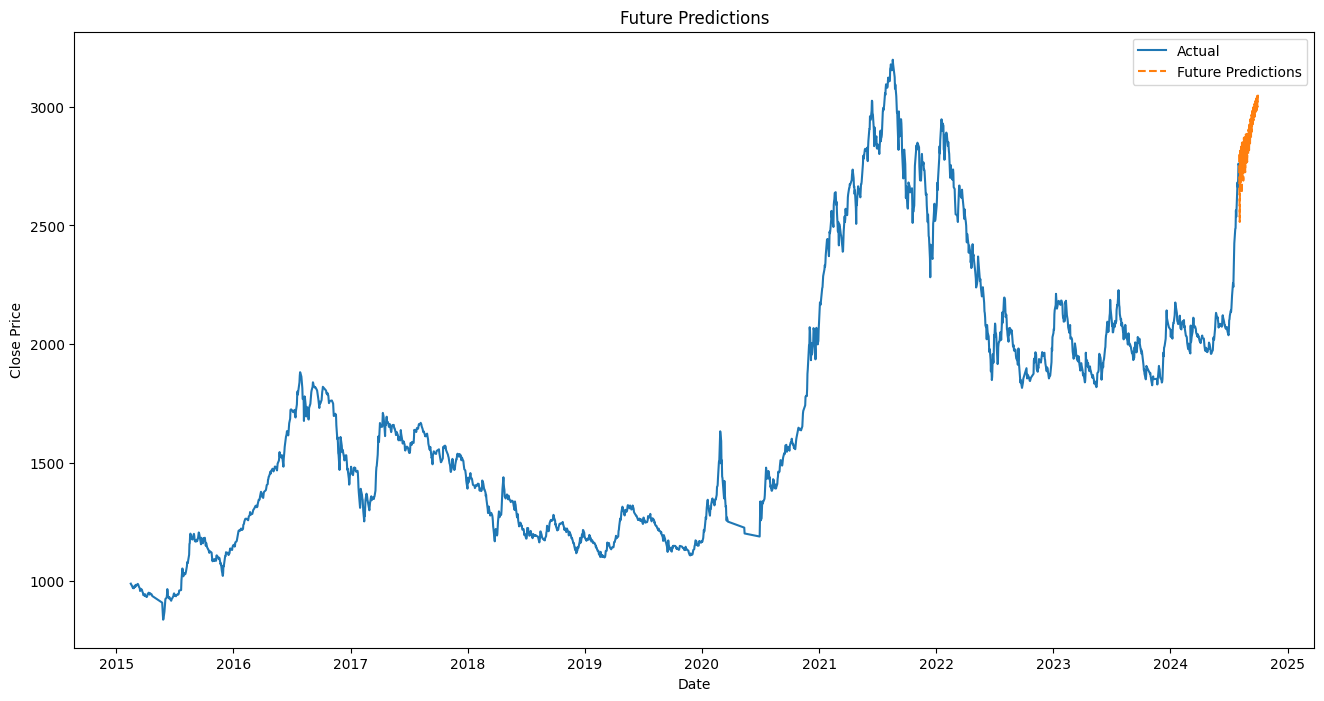

In [47]:
# Plot the future predictions
plt.figure(figsize=(16,8))
plt.plot(data['Date'], data['Close'], label='Actual')
plt.plot(future_df['Date'], future_df['Predicted Close'], label='Future Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('Future Predictions')
plt.show()

# Create a DataFrame for future predictions
future_dates = pd.date_range(data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=num_future_days)
print(pd.DataFrame({'Date': future_dates, 'Predicted Close': future_predictions}))

# Plot the actual data and future predictions
plt.figure(figsize=(16, 8))
plt.plot(data['Date'], data['Close'], label='Actual')
plt.plot(future_df['Date'], future_df['Predicted Close'], label='Future Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('Future Predictions')
plt.savefig('future_predictions.png')  # Save the plot
plt.show(block=True)  # Prevent the plot from disappearing immediately
